In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
import absorption_line_vel as vel
from absorption_line_vel import SpectrumSN_Lines, AbsorbLine

# read spec data
z = 0.0307
spec = '../../spectroscopy/ZTF20aayhacx_20200513_NOT_v4.ascii'
Spec1 = SpectrumSN_Lines(spec, z)
Spec = SpectrumSN_Lines(spec, 0)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

# 20200513_NOT

## Na 5890 & 5896

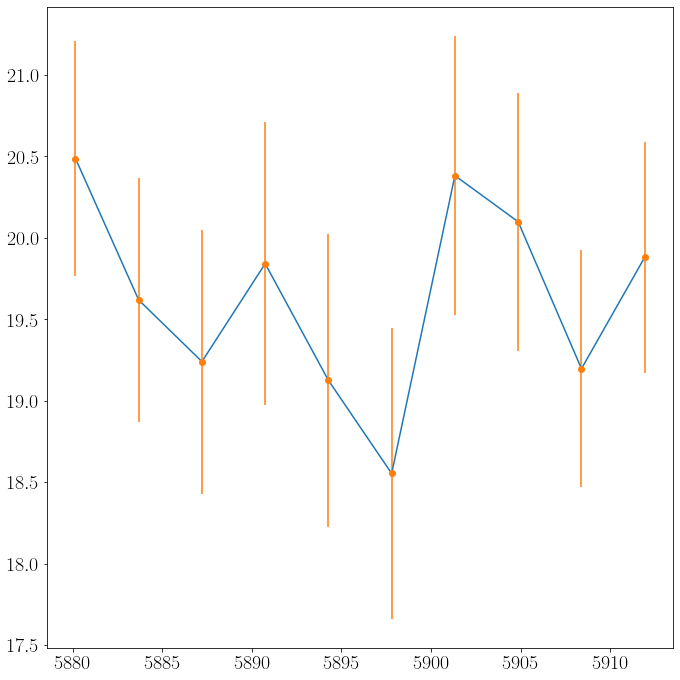

In [4]:
Spec.plot_line_region(5880, 5915)

In [13]:
Spec.add_line('NaI_5896', 5880, 5910, lines=[5889.950, 5895.924], rel_strength=[2, 1])

9 points within 5880.00 and 5910.00 angstroms.


../absorption_line_vel.py:145: UserWarning: Too few points within the wavelength range!
  warnings.warn('Too few points within the wavelength range!')
../absorption_line_vel.py:149: UserWarning: <=5 points within the wavelength range!
  warnings.warn(


 25%|██▌       | 5000/20000 [02:29<07:29, 33.40it/s]  


MCMC results:
Velocity pvf: 140 pm 194 km/s


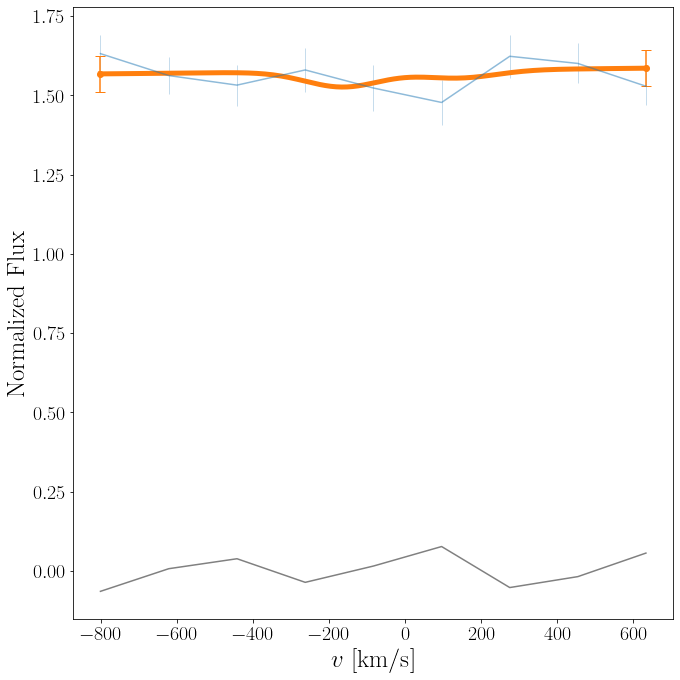

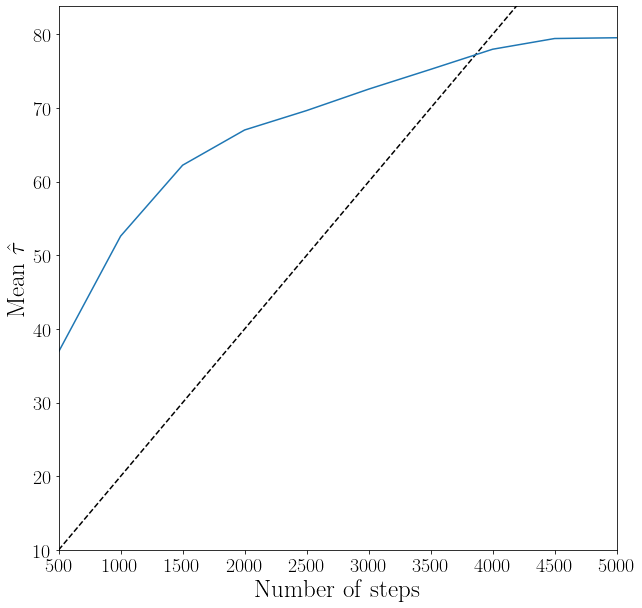

In [14]:
'''sampler = Spec.line['NaI_5896'].MCMC_sampler(initial=[1, 1, -100, 3, -5],
                                             normalize_unc=False,
                                             max_nsteps=1000)'''

sampler = Spec.line['NaI_5896'].MCMC_sampler(
    vel_flat=[-350, 350],
    var_max=1e4,
    initial=[1, 1, 0, 8, -5],
    normalize_unc=False,
    #Plot_mcmc=True,
    max_nsteps=20000,
    Plot_tau=True)

In [33]:
sample = sampler.get_chain(discard=700, flat=True, thin=1)
logprob = sampler.get_log_prob(discard=700, flat=True, thin=1)

Na = Spec.line['NaI_5896']
ratio = 2 / (Na.red_vel - Na.blue_vel) / (Na.red_fl[0]+Na.blue_fl[0])*\
            (Na.wv_line[-1] - Na.wv_line[0]) * np.sum(Na.rel_strength) * 1000
sig = np.exp(sample[:, -2] / 2)
EW = sample[:, -1] * -ratio
hist, bin_edges = np.histogram(EW, bins=100, density=True)
bins = (bin_edges[1:] + bin_edges[:-1]) / 2
width = bin_edges[1] - bin_edges[0]
arg = np.argsort(hist)

cred = 0.68  # credible region
dens_thres = np.inf
j = 0
while cred > 0:
    cred -= width * hist[arg[-1 - j]]
    dens_thres = hist[arg][-1 - j]
    j += 1
interval68 = bins[hist > dens_thres]

cred = 0.95-0.68  # credible region
while cred > 0:
    cred -= width * hist[arg[-1 - j]]
    dens_thres = hist[arg][-1 - j]
    j += 1
interval95 = bins[hist > dens_thres]

p0 = interval68[0]
p1 = interval68[-1]
p2 = interval95[-1]

In [16]:
EBV1 = lambda EW: (2.47 * EW / 1000 - 1.76)
EBV2 = lambda EW: (2.16 * EW / 1000 - 1.91)
EBV = lambda EW: (1.17 * EW / 1000 - 1.85)

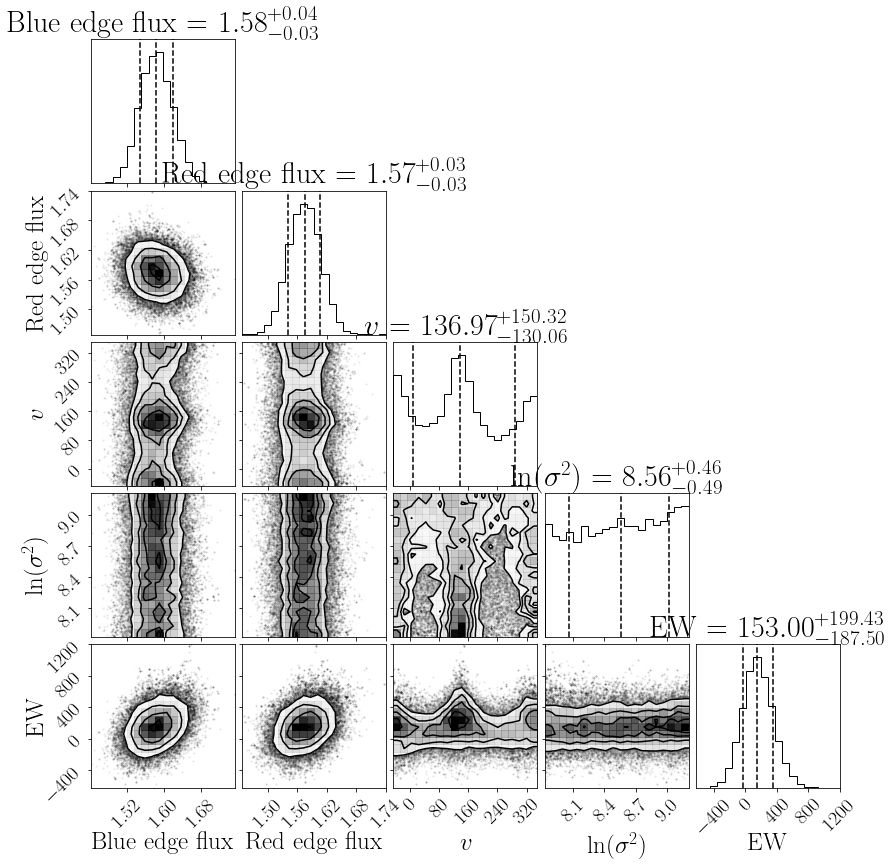

In [24]:
import corner
paramsNames = [
    r'$\mathrm{Blue\ edge\ flux}$', r'$\mathrm{Red\ edge\ flux}$', r'$v$',
    r'$\ln(\sigma^2)$', r'$\mathrm{EW}$'
]
chain = sample.copy()
chain[:, -1] = -ratio * sample[:, -1]
fig = corner.corner(chain[::8],
                    labels=paramsNames,
                    quantiles=[0.16, 0.50, 0.84],
                    show_titles=True)

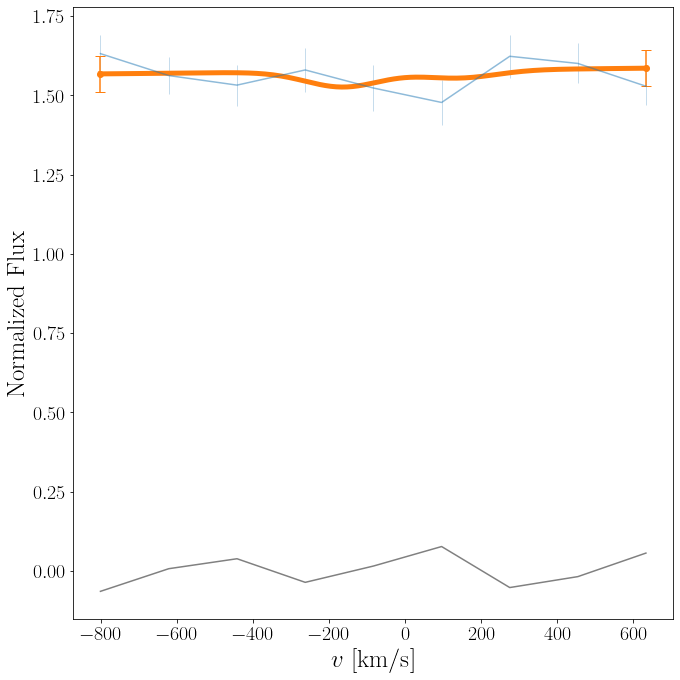

sigma = 99.3, EW = 142.3, E(B-V) = 0.021


In [25]:
the = Na.theta_MCMC
Na.plot_model(the)
print('sigma = {:.1f}, EW = {:.1f}, E(B-V) = {:.3f}'.format(
    np.exp(the[-2] / 2), -ratio * the[-1], 10**EBV(-ratio * the[-1])))

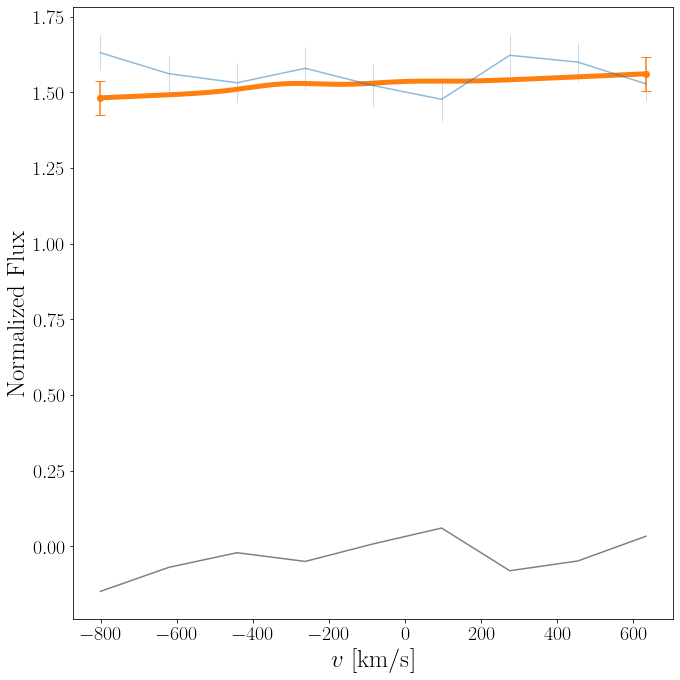

sigma = 100.0, EW = -57.3, E(B-V) = 0.012


In [26]:
the = sample[np.argmin(np.abs(sig - 100))]
Na.plot_model(the)
print('sigma = {:.1f}, EW = {:.1f}, E(B-V) = {:.3f}'.format(
    np.exp(the[-2] / 2), -ratio * the[-1], 10**EBV(-ratio * the[-1])))

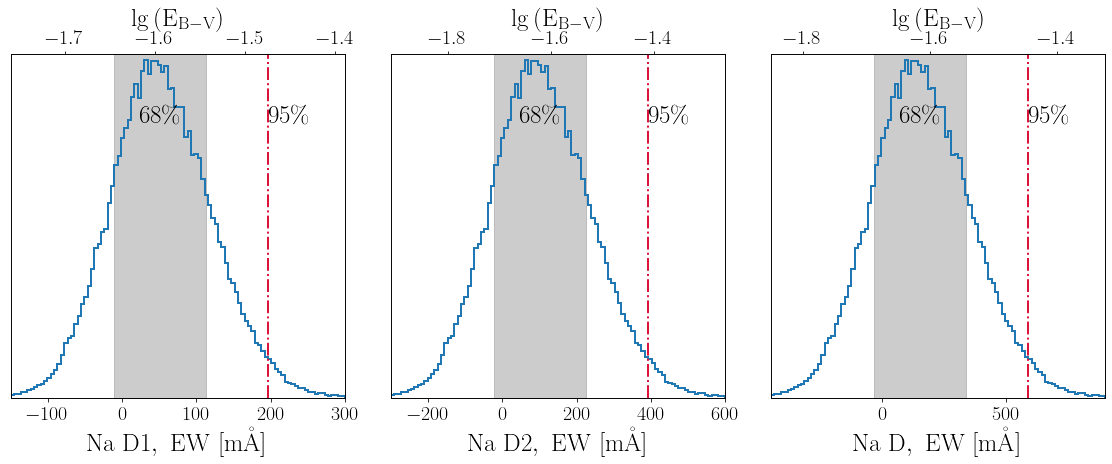

In [51]:
f, ax = plt.subplots(1, 3, figsize=(16, 7), sharey=True)
Range = 150

for k, a in enumerate(ax):
    a.fill_betweenx([0, 12000],
                    p0 / 3 * np.ones(2) * (k + 1),
                    p1 / 3 * np.ones(2) * (k + 1),
                    color='grey',
                    alpha=0.4)
    a.axvline(p2 / 3 * (k + 1), color='crimson', linestyle='-.', linewidth=2)
    a.text((p0 + p1) / 6 / Range / 3 + 1 / 3,
           0.8,
           r'$68\%$',
           transform=a.transAxes,
           ha='center')
    a.text(p2 / 3 / Range / 3 + 1 / 3, 0.8, r'$95\%$', transform=a.transAxes)
    a.hist(EW / 3 * (k + 1),
           histtype='step',
           bins=100,
           range=[-Range * (k + 1), Range * 2 * (k + 1)],
           linewidth=2)
    a.set_xlim(-Range * (k + 1), Range * 2 * (k + 1))
    a.set_ylim(0, 12000)
    a.set_yticks([])

ax[0].set_xlabel(r'$\mathrm{Na\ D1,\ EW}\ [\mathrm{m\mathring{A}}]$')
ax02 = ax[0].twiny()
ax02.set_xlabel(r'$\lg\left(\mathrm{E_{\mathrm{B}-\mathrm{V}}}\right)$')
ax02.set_xlim(EBV1(0), EBV1(Range))

ax[1].set_xlabel(r'$\mathrm{Na\ D2,\ EW}\ [\mathrm{m\mathring{A}}]$')
ax12 = ax[1].twiny()
ax12.set_xlabel(r'$\lg\left(\mathrm{E_{\mathrm{B}-\mathrm{V}}}\right)$')
ax12.set_xlim(EBV2(0), EBV2(Range * 2))

ax[2].set_xlabel(r'$\mathrm{Na\ D,\ EW}\ [\mathrm{m\mathring{A}}]$')
ax22 = ax[2].twiny()
ax22.set_xlabel(r'$\lg\left(\mathrm{E_{\mathrm{B}-\mathrm{V}}}\right)$')
ax[2].set_xlim(-Range * 3, Range * 6)
ax22.set_xlim(EBV(0), EBV(Range * 3))

f.tight_layout()

In [52]:
10**(EBV(p1)), 10**(EBV(p2))

(0.03523632547313953, 0.06888101942138444)

## Si II 6355

<AxesSubplot:>

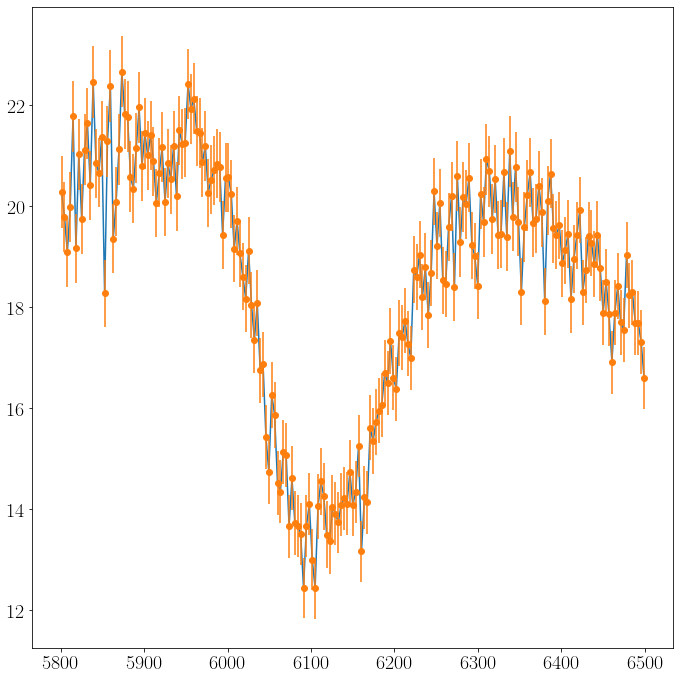

In [4]:
Spec1.plot_line_region(5800, 6500)

In [8]:
Spec1.add_line('SiII_6355', 5900, 6350, lines=[6371.359, 6347.103])
Spec1.line['SiII_6355'].LS_estimator()

130 points within 5900.00 and 6350.00 angstroms.


Normalize factor = 1.058


  5%|█▊                                   | 2500/50000 [00:18<06:00, 131.93it/s]


MCMC results:
Velocity 1: -11748 pm 70 km/s


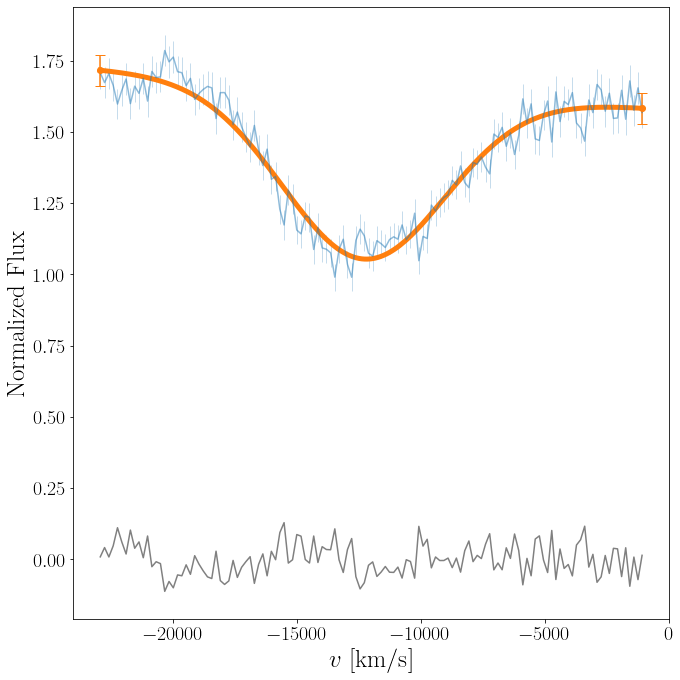

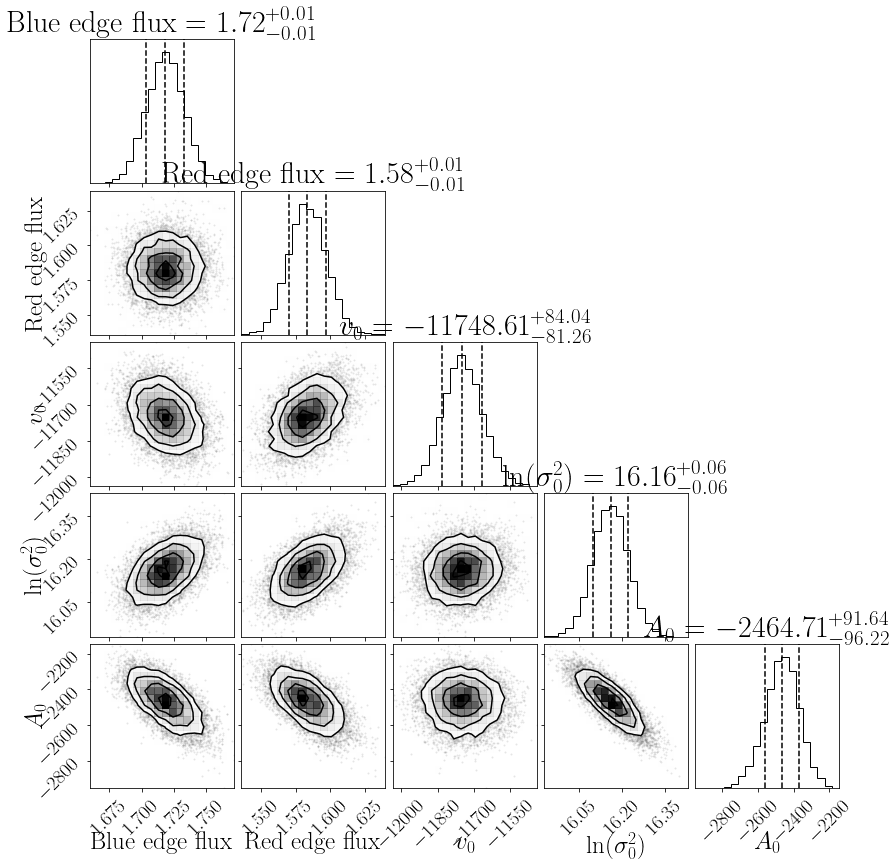

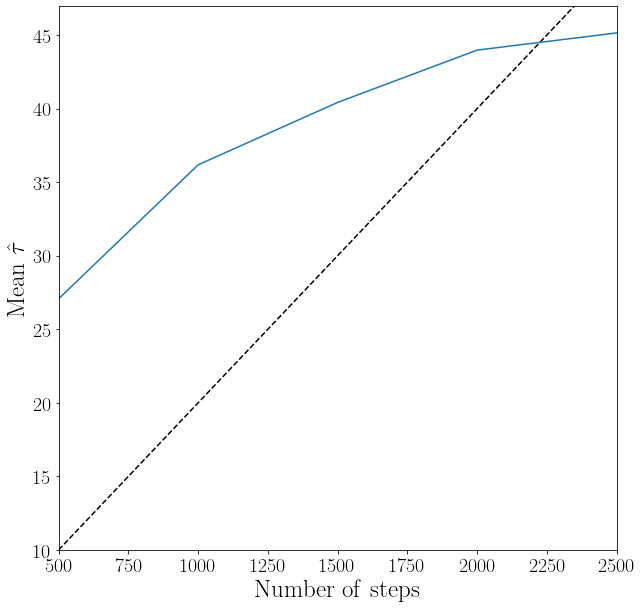

In [12]:
sampler = Spec1.line['SiII_6355'].MCMC_sampler(
    initial=Spec1.line['SiII_6355'].theta_MCMC,
    normalize_unc='LS',
    Plot_mcmc=True,
    Plot_tau=True)

## Ca II IRT

<AxesSubplot:>

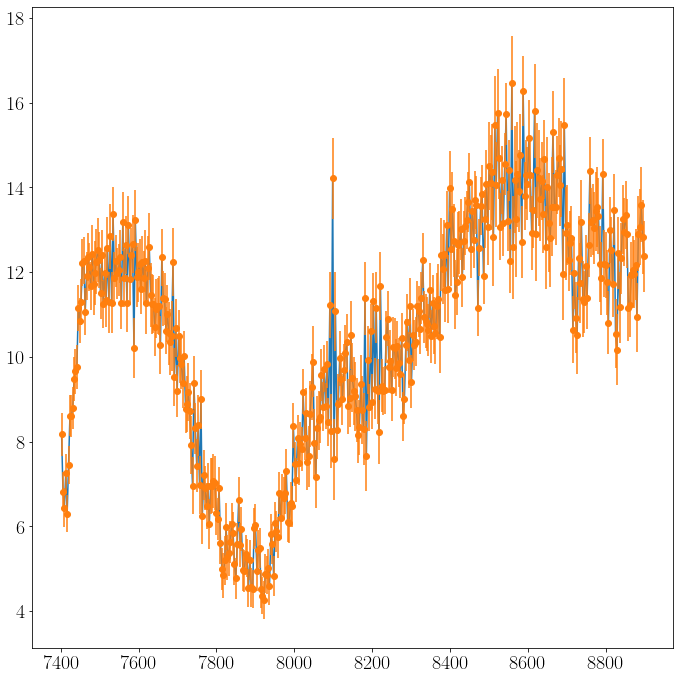

In [13]:
Spec1.plot_line_region(7400, 8900)

In [14]:
Spec1.add_line('CaII_IRT/CaII_IRT',
               7550,
               8650,
               lines=[[8498.018, 8542.089, 8662.140],
                      [8498.018, 8542.089, 8662.140]],
               rel_strength=[[], []])
Spec1.line['CaII_IRT/CaII_IRT'].LS_estimator(guess=(1, 1, -25000, 15, -1000,
                                                    -12000, 15, -1000))

304 points within 7550.00 and 8650.00 angstroms.
LS estimation:
Velocity 1: -24541 km/s
Velocity 2: -11130 km/s


Normalize factor = 1.162


100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 65.24it/s]


MCMC results:
Velocity 1: -24526 pm 158 km/s
Velocity 2: -11448 pm 272 km/s
Normalize factor = 1.177


  9%|███▍                                  | 4500/50000 [01:09<11:42, 64.75it/s]

MCMC results:
Velocity 1: -24558 pm 106 km/s
Velocity 2: -11169 pm 230 km/s


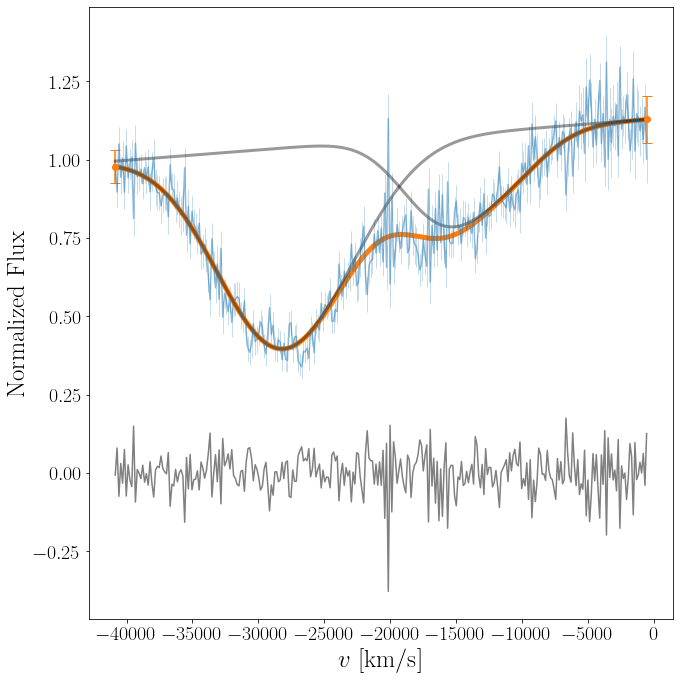

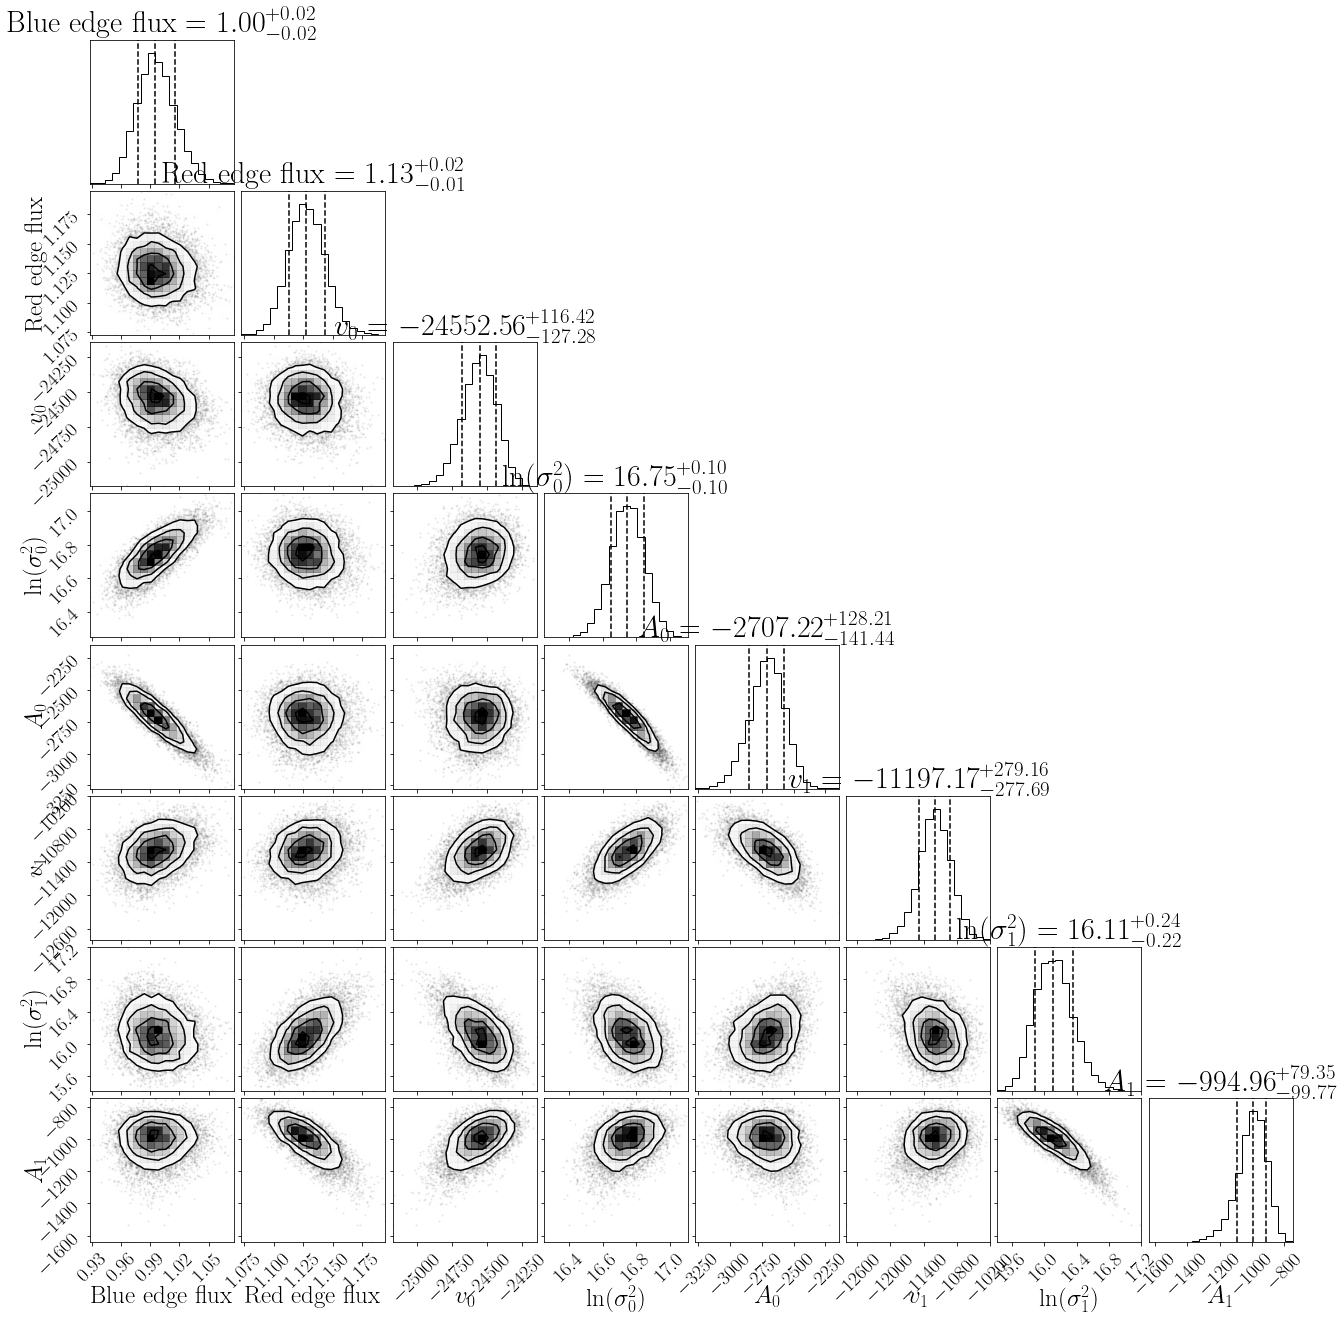

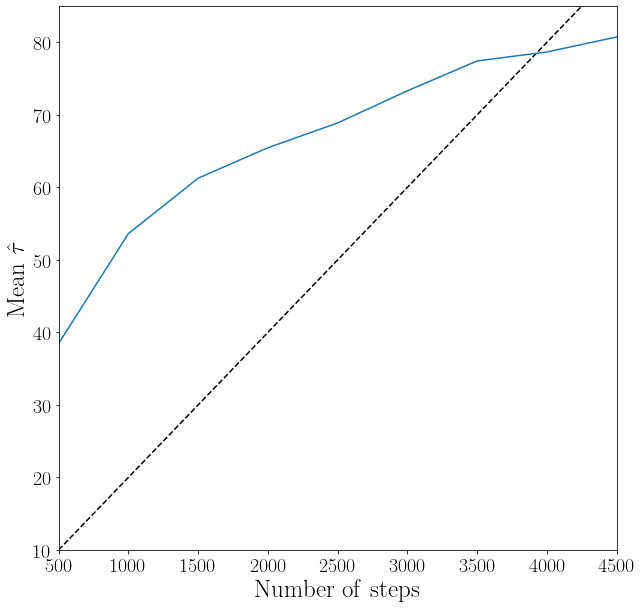

In [16]:
mu1 = -24000
mu2 = -11750
sampler = Spec1.line['CaII_IRT/CaII_IRT'].MCMC_sampler(
    mu_prior=[mu1, mu2],
    var_prior=[1e7, 1e7],
    initial=[1, 1, -25000, 15, -1000, -12000, 15, -1000],
    normalize_unc='LS',
    max_nsteps=1000,
    Plot_model=False)
sampler = Spec1.line['CaII_IRT/CaII_IRT'].MCMC_sampler(
    mu_prior=[mu1, mu2],
    var_prior=[1e7, 1e7],
    initial=Spec1.line['CaII_IRT/CaII_IRT'].theta_MCMC,
    normalize_unc='MCMC',
    Plot_mcmc=True,
    Plot_tau=True)